# Asia network example
network source and some code pieces from pgmpy demo

In [1]:
import numpy as np
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.factors.discrete import DiscreteFactor

## Get example model
list of possible options at the end of this file

In [2]:
from pgmpy.utils import get_example_model
model = get_example_model('asia')
model.get_cpds()

[<TabularCPD representing P(asia:2) at 0x234adc08880>,
 <TabularCPD representing P(bronc:2 | smoke:2) at 0x234adc08bb0>,
 <TabularCPD representing P(dysp:2 | bronc:2, either:2) at 0x234adc08640>,
 <TabularCPD representing P(either:2 | lung:2, tub:2) at 0x234adc08490>,
 <TabularCPD representing P(lung:2 | smoke:2) at 0x234adc082b0>,
 <TabularCPD representing P(smoke:2) at 0x234adc083d0>,
 <TabularCPD representing P(tub:2 | asia:2) at 0x234adc08c70>,
 <TabularCPD representing P(xray:2 | either:2) at 0x234adc08f40>]

In [3]:
model.nodes()

NodeView(('asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp'))

In [4]:
model.get_cardinality('smoke')

2

In [5]:
# Getting the local independencies of a variable.
model.local_independencies('dysp')

(dysp ⟂ smoke, xray, tub, asia, lung | bronc, either)

In [6]:
# Getting all the local independencies in the network.
model.local_independencies(['bronc', 'smoke', 'lung'])

(bronc ⟂ xray, tub, asia, lung, either | smoke)
(smoke ⟂ asia, tub)
(lung ⟂ bronc, asia, tub | smoke)

In [7]:
model.active_trail_nodes('smoke')

{'smoke': {'bronc', 'dysp', 'either', 'lung', 'smoke', 'xray'}}

In [8]:
model.active_trail_nodes('smoke', observed='xray')

{'smoke': {'asia', 'bronc', 'dysp', 'either', 'lung', 'smoke', 'tub'}}

In [9]:
model.get_parents('tub')

['asia']

## Conditional probability distribution

In [48]:
print(model.get_cpds('xray'))

+-----------+-------------+------------+
| either    | either(yes) | either(no) |
+-----------+-------------+------------+
| xray(yes) | 0.98        | 0.05       |
+-----------+-------------+------------+
| xray(no)  | 0.02        | 0.95       |
+-----------+-------------+------------+


## Factor: more general probability potential

In [11]:
tub=model.get_cpds('tub')
print(tub.to_factor())

+----------+-----------+-----------------+
| tub      | asia      |   phi(tub,asia) |
+==========+===========+=================+
| tub(yes) | asia(yes) |          0.0500 |
+----------+-----------+-----------------+
| tub(yes) | asia(no)  |          0.0100 |
+----------+-----------+-----------------+
| tub(no)  | asia(yes) |          0.9500 |
+----------+-----------+-----------------+
| tub(no)  | asia(no)  |          0.9900 |
+----------+-----------+-----------------+


In [12]:
model.check_model()

True

## Daft graph display

node coordinates needed

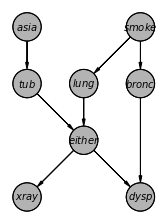

In [13]:
import matplotlib.pyplot as plt
import daft

plt.rcParams['figure.facecolor'] = 'white'
#
pos={'asia': (1, 4), 'smoke': (3, 4), 'tub': (1, 3), 'lung': (2, 3),
                         'bronc': (3, 3),'either': (2, 2),'xray': (1, 1),'dysp': (3, 1)}
model.to_daft(node_pos=pos).render()

In [58]:
from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
inference = BayesianModelSampling(model)
inference.forward_sample(size=2,show_progress=True)
evidence=[State('xray','yes')]
inference.likelihood_weighted_sample(evidence=evidence, size=4, show_progress=False)
rinference.rejection_sample(evidence=evidence, size=4, show_progress=False)


Generating for node: tub:   0%|                          | 0/8 [00:00<?, ?it/s]c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:521: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  warn(
Generating for node: dysp: 100%|████████████████| 8/8 [00:00<00:00, 222.35it/s]


In [101]:
import scipy
rj=inference.rejection_sample(evidence=evidence, size=10, show_progress=False)
cnts=rj.groupby(['lung','tub'])['asia'].count()
summ=cnts.sum()
res=[('yes','no'),('no','no'),('no','yes')]
sampled_prob=[cnts[(a,b)]/summ for (a,b) in res]
precise=infer.query(['lung','tub'], evidence={'xray': 'yes'},show_progress=False)
precise_prob=[precise.get_value(lung=a, tub=b) for (a,b) in res]
scipy.stats.entropy(sampled_prob,precise_prob)

0.1397357241715437

In [64]:
print(infer.query(['lung','tub'], evidence={'xray': 'yes'},show_progress=False))

+----------+-----------+-----------------+
| tub      | lung      |   phi(tub,lung) |
+==========+===========+=================+
| tub(yes) | lung(yes) |          0.0051 |
+----------+-----------+-----------------+
| tub(yes) | lung(no)  |          0.0873 |
+----------+-----------+-----------------+
| tub(no)  | lung(yes) |          0.4836 |
+----------+-----------+-----------------+
| tub(no)  | lung(no)  |          0.4240 |
+----------+-----------+-----------------+


In [42]:
from pgmpy.sampling import GibbsSampling #Bayesian and Markov networks
gibbs_chain = GibbsSampling(model)
gen=gibbs_chain.generate_sample(size=1)
#[s for s in gen]
gibbs_chain.sample(size=20)

c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:521: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  warn(
c:\users\marta\appdata\local\programs\python\python38\lib\site-packages\pgmpy\sampling\Sampling.py:404: RuntimeWarning: invalid value encountered in true_divide
  kernel[tup] = prod_cpd_reduced.values / sum(prod_cpd_reduced.values)
100%|█████████████████████████████████████████| 19/19 [00:00<00:00, 700.53it/s]


,asia,tub,smoke,lung,bronc,either,xray,dysp
0,0,0,1,1,0,1,1,0
1,1,1,0,1,0,1,1,0
2,1,1,0,1,0,1,1,0
3,1,1,1,1,0,1,1,0
4,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1
8,1,1,0,1,0,1,1,1
9,1,1,1,1,1,1,1,0


In [14]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)
g_dist = infer.query(['lung'],show_progress=False)
print(g_dist)

+-----------+-------------+
| lung      |   phi(lung) |
+===========+=============+
| lung(yes) |      0.0550 |
+-----------+-------------+
| lung(no)  |      0.9450 |
+-----------+-------------+


Width: 5
['either', 'tub', 'bronc', 'lung', 'asia', 'smoke', 'xray', 'dysp']


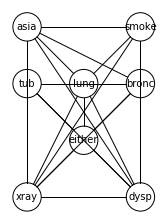

In [15]:
from pgmpy.inference.EliminationOrder import WeightedMinFill
import matplotlib.pyplot as plt
import daft
import sys

plt.rcParams['figure.facecolor'] = 'white'

## Transforms pgmpy.models.BayesianModel to daft.PGM
def to_daft(model,pos):
    daft_model=daft.PGM()
    for node in model.nodes:
        daft_model.add_node(daft.Node(node, node,pos[node][0],pos[node][1]))
    for edge in model.edges:
        try:
            daft_model.add_edge(edge[0],edge[1],directed=False)
        except:
            print(sys.exc_info())
    return daft_model

order=['either', 'tub','bronc','lung', 'asia', 'smoke', 'xray', 'dysp']
#order=WeightedMinFill(model).get_elimination_order(nodes=None, show_progress=False)
gg=infer.induced_graph(order)

print('Width: {}'.format(infer.induced_width(order)))
print(order)
mm=to_daft(gg,pos)
mm.render()



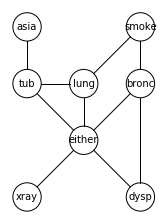

In [16]:
moral=model.to_markov_model()
daft_moral=to_daft(moral, pos)
daft_moral.render()

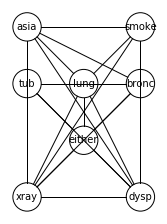

In [17]:
triangulated=moral.triangulate(order=order)#(heuristic='H6')
daft_triangulated=to_daft(triangulated, pos)
daft_triangulated.render()

In [18]:
elim_o=WeightedMinFill(model)#.get_elimination_order(nodes=None, show_progress=False)
for node in order:
    fill=list(elim_o.fill_in_edges(node))
    if len(fill)>0:
            print('{}: fills {}'.format(node,fill))

either: fills [('xray', 'dysp')]
smoke: fills [('lung', 'bronc')]


## Junction Tree

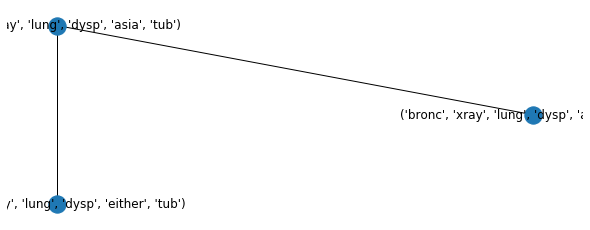

In [19]:
import networkx as nx
jt=triangulated.to_junction_tree()
plt.rcParams["figure.figsize"] = (8,3)
nx.draw_circular(jt,with_labels=True,)

In [20]:
jt.nodes
# 'lung', 'bronc', 'dysp' must be also in the inner node.

NodeView((('bronc', 'xray', 'lung', 'dysp', 'asia', 'smoke'), ('bronc', 'xray', 'lung', 'dysp', 'asia', 'tub'), ('bronc', 'xray', 'lung', 'dysp', 'either', 'tub')))

NodeView((('either', 'smoke', 'dysp', 'bronc'), ('either', 'smoke', 'dysp', 'asia', 'xray'), ('either', 'smoke', 'lung', 'asia'), ('either', 'tub', 'asia', 'lung')))

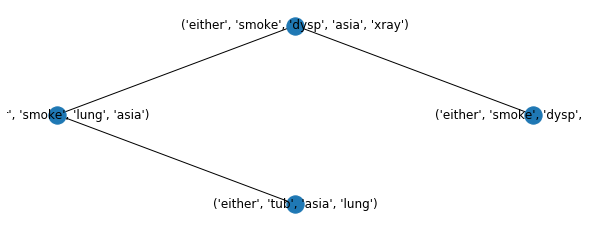

In [21]:
triangulated=moral.triangulate()#(heuristic='H6')
jt=triangulated.to_junction_tree()
plt.rcParams["figure.figsize"] = (8,3)
nx.draw_circular(jt,with_labels=True,)
jt.nodes

In [22]:
print(infer.query(['lung'], evidence={'xray': 'yes'},show_progress=False))

+-----------+-------------+
| lung      |   phi(lung) |
+===========+=============+
| lung(yes) |      0.4887 |
+-----------+-------------+
| lung(no)  |      0.5113 |
+-----------+-------------+


In [23]:
print(infer.query(['lung'], evidence={'xray': 'yes','smoke':'yes'},show_progress=False))

+-----------+-------------+
| lung      |   phi(lung) |
+===========+=============+
| lung(yes) |      0.6460 |
+-----------+-------------+
| lung(no)  |      0.3540 |
+-----------+-------------+


In [24]:
print(infer.query(['lung'], evidence={'xray': 'yes','asia':'yes'},show_progress=False))

+-----------+-------------+
| lung      |   phi(lung) |
+===========+=============+
| lung(yes) |      0.3715 |
+-----------+-------------+
| lung(no)  |      0.6285 |
+-----------+-------------+


## Read and write models in pgmpy


Unfortunatelly, the standard *.net format is not supported.

In [25]:
from pgmpy.readwrite import BIFReader, BIFWriter
writer = BIFWriter(model)
writer.write_bif(filename='{}.bif'.format('example'))

## Other sample models

The continuous ones did not work when I tried them.



pgmpy examples

Options:
            Small Networks:
                1. asia
                2. cancer
                3. earthquake
                4. sachs
                5. survey
            Medium Networks:
                1. alarm
                2. barley
                3. child
                4. insurance
                5. mildew
                6. water
            Large Networks:
                1. hailfinder
                2. hepar2
                3. win95pts
            Very Large Networks:
                1. andes
                2. diabetes
                3. link
                4. munin1
                5. munin2
                6. munin3
                7. munin4
                8. pathfinder
                9. pigs
                10. munin
        Gaussian Bayesian Network Options:
                1. ecoli70
                2. magic-niab
                3. magic-irri
                4. arth150
        Conditional Linear Gaussian Bayesian Network Options:
                1. sangiovese
                2. mehra

In [26]:
from pgmpy.utils import get_example_model
names=['earthquake','barley']
model2 = get_example_model(names[1])


In [27]:
import graphviz
dot = graphviz.Digraph(comment='')

for nd in model2.nodes():
    dot.node(nd,nd)

dot.edges(model2.edges)
dot.render('test-output/{}.gv'.format(names[1]), view=False) 

'test-output\\barley.gv.pdf'